In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns

In [2]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [6]:
hw=pd.read_csv('cluster_hw.csv')

In [7]:
del hw['Unnamed: 0']
hw.head()

,feat1,feat2,Class
0,1.126107,-0.363169,0
1,0.380427,0.381545,1
2,-0.095709,-0.350235,1
3,1.182031,0.046286,0
4,-0.657046,1.106598,0


<AxesSubplot:xlabel='feat1', ylabel='feat2'>

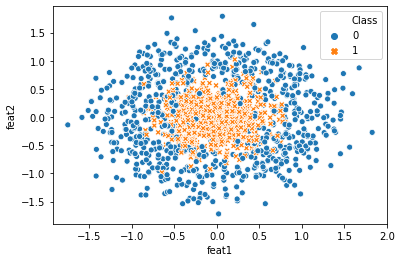

In [8]:
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=hw)

So, this data set has two pretty distinct clusters that are circular, with one inside the other. Intuitively, it seems like a linear decision boundary will have a pretty difficult time separating the two, but a quadratic boundary could work. 

Let's see how plain logistic regression (with a linear boundary works).

In [10]:
X=hw[['feat1','feat2']]
y=hw['Class']

Split the data into an training and test set and fit the model.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [13]:
clf = linear_model.LogisticRegression(random_state=0)
LRclf = clf.fit(X_train[['feat1','feat2']], y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Now see how the model does on test data.

In [17]:
pd.crosstab(LRclf.predict(X_test[['feat1','feat2']]),y_test)

Class,0,1
row_0,,
0,99,111
1,126,114


In [19]:
accuracy_score(LRclf.predict(X_test[['feat1','feat2']]),y_test)

0.47333333333333333

Like we anticipated-- the accuracy is not good! 

Also, note that the model will almost always do better on the training data than on the test data-- that's why it's so important to have test data that the model has never seen!

In [24]:
accuracy_score(LRclf.predict(X_train[['feat1','feat2']]),y_train)

0.5085714285714286

Here's the decision boundary...

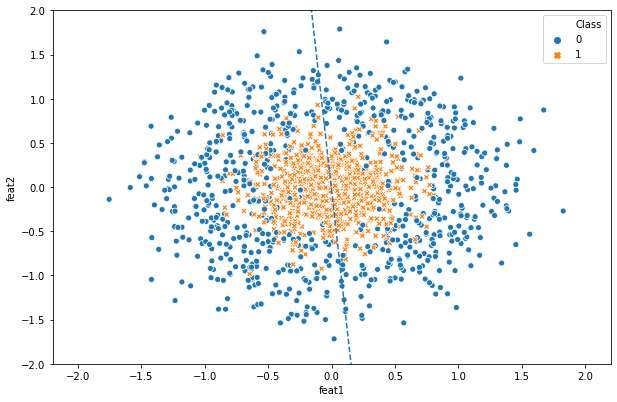

In [23]:
b=LRclf.intercept_
b1=LRclf.coef_[0][0]
b2=LRclf.coef_[0][1]

f, ax = plt.subplots(figsize=(10, 6.5))
sns.scatterplot(x="feat1", y="feat2",
                hue="Class", style="Class",
                data=hw, ax=ax)
x_vals = np.linspace(-2,2,100)
y_vals = -b/b2 - (b1/b2) * x_vals
plt.ylim([-2, 2])
plt.plot(x_vals, y_vals, '--')

Now let's try models with more flexible decision boundaries by using polynomials of higher degree to model the log-odds. We'll use cross-vaidation to choose between the possible models, and use accuracy as the metric to validate models on the test fold. 

First we'll include the higher order features by adding the squares, cubes, and 4th and 5th powers of both feat1 and feat 2 to the dataframe.

In [25]:
X['f12']=X['feat1']**2 #feature one squared etc.
X['f22']=X['feat2']**2
X['f13']=X['feat1']**3
X['f23']=X['feat2']**3
X['f14']=X['feat1']**4
X['f24']=X['feat2']**4
X['f15']=X['feat1']**5
X['f25']=X['feat2']**5

Now split the data again:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

And run 5-fold cross validation for each potential model from ordinary linear log-odds (degree 1) to fifth porder (degree 5). 

In [27]:
lcv1_results = cross_validate(clf, X_train[['feat1','feat2']], y_train, cv=5,scoring='accuracy')
lcv2_results = cross_validate(clf, X_train[['feat1','feat2','f12','f22']], y_train, cv=5,scoring='accuracy')
lcv3_results = cross_validate(clf, X_train[['feat1','feat2','f12','f22','f13','f23']], y_train, cv=5,scoring='accuracy')
lcv4_results = cross_validate(clf, X_train[['feat1','feat2','f12','f22','f13','f23','f14','f24']], y_train, cv=5,scoring='accuracy')
lcv5_results = cross_validate(clf, X_train[['feat1','feat2','f12','f22','f13','f23','f14','f24','f15','f25']], y_train, cv=5,scoring='accuracy')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Let's see which model has the best average accuracy over the five folds:

In [28]:
print(lcv1_results['test_score'].mean(),lcv2_results['test_score'].mean(),lcv3_results['test_score'].mean(),lcv4_results['test_score'].mean(),lcv5_results['test_score'].mean())

0.48285714285714293 0.8742857142857142 0.8742857142857142 0.8685714285714285 0.8676190476190475


The quadratic (degree 2) model! Note the dramatic jump in average accuracy followed by slightly worse performance on the higher (than degree 2) order models. (As we anticipated above.) Let's refit the model using the whole training set and then   draw the decision-boundary.

In [31]:
deg2mod=linear_model.LogisticRegression(random_state=0).fit(X_train[['feat1','feat2','f12','f22']], y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 500), np.linspace(-2, 2, 500))
x2=xx**2
y2=yy**2
X_grid = np.c_[xx.ravel(), yy.ravel(),x2.ravel(),y2.ravel()]

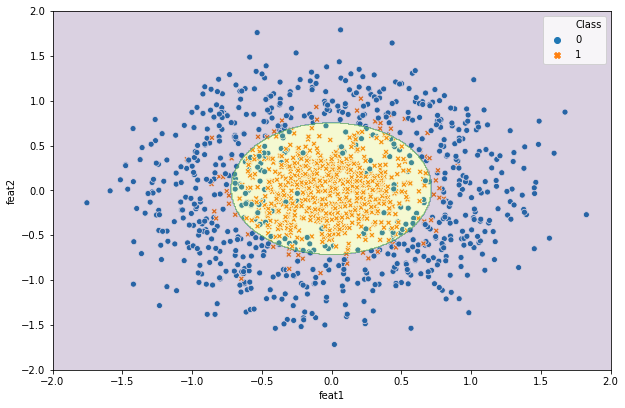

In [35]:
zz_lr2 = deg2mod.predict_proba(X_grid)[:,1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(10, 6.6))
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=hw)
plt.contourf(xx, yy, zz_lr2 > 0.5, alpha=0.2)

Much better! I think this is close to optimal -- a more flexible model won't help much. In particular, look at the observations that are misclassified. It seems to me like they are in the wrong place and the model can be excused for these errors! 